In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")
torch.manual_seed(42)

In [8]:
df = pd.read_csv("/nmhs2/hari/work/UAV/Projects/real_estate/CSUSHPINSA.csv")
df.head()


,DATE,CSUSHPISA
0,1987-01-01,63.732
1,1987-02-01,64.131
2,1987-03-01,64.467
3,1987-04-01,64.972
4,1987-05-01,65.546


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       466 non-null    object 
 1   CSUSHPISA  466 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.4+ KB


In [10]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

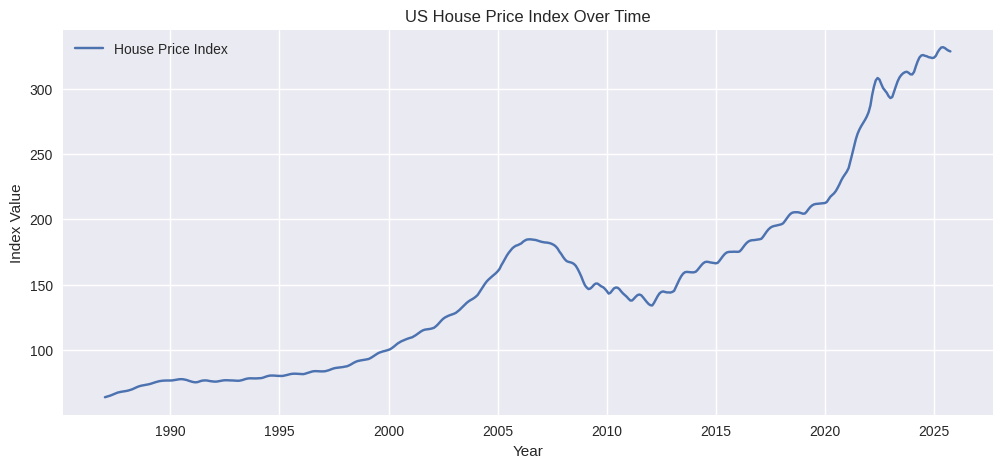

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['CSUSHPISA'], label="House Price Index")
plt.title("US House Price Index Over Time")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.legend()
plt.show()


In [12]:
df.describe()

,CSUSHPISA
count,466.000000
mean,151.639255
std,72.269566
min,63.732000
25%,83.536500
50%,144.175500
75%,183.646000
max,331.627000


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['CSUSHPISA']])

In [14]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12  # 12 months
X, y = create_sequences(scaled_data, SEQ_LENGTH)


In [15]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
class RealEstateDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [17]:
train_dataset = RealEstateDataset(X_train, y_train)
test_dataset = RealEstateDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {train_loss/len(train_loader):.6f}")


Epoch [1/50] | Loss: 0.064749
Epoch [2/50] | Loss: 0.025406
Epoch [3/50] | Loss: 0.022001
Epoch [4/50] | Loss: 0.018272
Epoch [5/50] | Loss: 0.011968
Epoch [6/50] | Loss: 0.003083
Epoch [7/50] | Loss: 0.001728
Epoch [8/50] | Loss: 0.000884
Epoch [9/50] | Loss: 0.000687
Epoch [10/50] | Loss: 0.000656
Epoch [11/50] | Loss: 0.000641
Epoch [12/50] | Loss: 0.000584
Epoch [13/50] | Loss: 0.000484
Epoch [14/50] | Loss: 0.000498
Epoch [15/50] | Loss: 0.000403
Epoch [16/50] | Loss: 0.000374
Epoch [17/50] | Loss: 0.000339
Epoch [18/50] | Loss: 0.000329
Epoch [19/50] | Loss: 0.000309
Epoch [20/50] | Loss: 0.000321
Epoch [21/50] | Loss: 0.000351
Epoch [22/50] | Loss: 0.000399
Epoch [23/50] | Loss: 0.000317
Epoch [24/50] | Loss: 0.000293
Epoch [25/50] | Loss: 0.000280
Epoch [26/50] | Loss: 0.000301
Epoch [27/50] | Loss: 0.000295
Epoch [28/50] | Loss: 0.000290
Epoch [29/50] | Loss: 0.000329
Epoch [30/50] | Loss: 0.000291
Epoch [31/50] | Loss: 0.000294
Epoch [32/50] | Loss: 0.000324
Epoch [33/50] | L

In [28]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        predictions.append(preds.cpu().numpy())

predictions = np.vstack(predictions)


In [29]:
y_test_inv = scaler.inverse_transform(y_test)
predictions_inv = scaler.inverse_transform(predictions)


In [30]:
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae = mean_absolute_error(y_test_inv, predictions_inv)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 30.29
MAE: 27.13


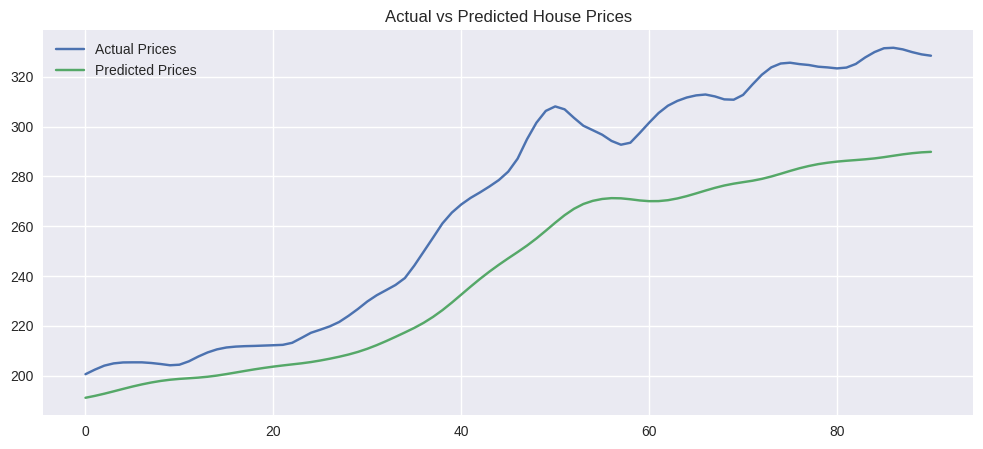

In [31]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual Prices")
plt.plot(predictions_inv, label="Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.show()
